# Modules for Import

In [1]:
import pandas as pd
from scipy.stats import shapiro

from datetime import datetime, date

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.io as pio

from IPython.display import HTML, Javascript, display

from pypalettes import load_cmap
import seaborn as sns
import cufflinks as cf
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
from plotly.offline import init_notebook_mode

# Read df from disk 

In [2]:
# Read from CSV
df = pd.read_csv('nba-stats-data.csv', low_memory=False)
print(df)

        assists  blocks comment  defReb   fga  fgm   fgp  fta  ftm    ftp  \
0           3.0     1.0     NaN     7.0   6.0  1.0  16.7  4.0  3.0   75.0   
1           3.0     1.0     NaN     7.0   6.0  1.0  16.7  4.0  3.0   75.0   
2           3.0     1.0     NaN     7.0   6.0  1.0  16.7  4.0  3.0   75.0   
3           0.0     0.0     NaN     5.0   8.0  5.0  62.5  0.0  0.0    0.0   
4           1.0     0.0     NaN     6.0  10.0  5.0  50.0  4.0  4.0  100.0   
...         ...     ...     ...     ...   ...  ...   ...  ...  ...    ...   
394809      1.0     0.0     NaN     2.0   7.0  0.0   0.0  1.0  1.0  100.0   
394810      0.0     1.0     NaN     1.0  10.0  1.0  10.0  3.0  3.0  100.0   
394811      2.0     1.0     NaN     6.0   5.0  3.0  60.0  0.0  0.0    0.0   
394812      5.0     0.0     NaN     3.0  12.0  6.0  50.0  5.0  4.0   80.0   
394813      0.0     0.0     NaN     0.0   1.0  0.0   0.0  0.0  0.0    0.0   

        ...         DOB   age  feet  meters  position active  jersey_number

In [3]:
# set season (year) as main DF index to allow for time series analysis of player data
df = df.reset_index().set_index('season')
df.index = pd.to_datetime(df.index, format='%Y').to_period('Y')
df = df.sort_index(axis=0)

## Data Analysis

- Set font size
- Define function to create time series plot
- Define function to summarise top players for a given performance statistic (i.e. Points scored, Blocks, Steals, Rebounds, Field Goal Percentage etc.)
- Define function to highlight cell greater or equal threshold of 0.7 and less than 1

In [4]:
fontsize=22

# convenience function for time series plots
def create_ts_plot(data, title, ylabel, color="navy", rhs_vals=None):
    # create a time series plot
    pd.options.plotting.backend = "matplotlib"
    ax = data.plot(figsize=(9, 4.3), legend=False, lw=2, zorder=3, color=color)
    plt.title(title, fontsize=fontsize-1)
    plt.ylabel(ylabel)
    plt.xlabel(None)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    return ax

# convenience function to aggregate top players by a given statistic or feature
def summary_top_players(grp, stat,  sort_by = 'mean', results = 10):
    df[stat] = pd.to_numeric(df[stat], errors='coerce')# handle nans and plusMinus values which are char in format ''+/-[0-9]*'
    df_aggs = round(df.groupby([grp])[stat].agg(['mean', 'sum']), 2)
    return df_aggs.sort_values(by=sort_by, ascending=False).head(results)

# convenience method to highlight data frame cell lime green
def highlighter(cell_value, thresh_lower = 0.7, thresh_upper = 0.99):
    if cell_value < thresh_upper and cell_value >= thresh_lower:
        return "background-color: #32CD32"
    elif cell_value == 1:
        return "background-color: yellow"

- Convert pounds feature to numeric column and get mean value

In [5]:
df['pounds'] = pd.to_numeric(df['pounds'])
print("Average player weight %s lbs." % round(df['pounds'].mean(skipna = True), 2))

Average player weight 219.89 lbs.


- Convert meters feature to numeric column and get mean value

In [6]:
df['meters'] = pd.to_numeric(df['meters'])
round(df['meters'].mean(skipna = True), 2)
print("Average player height %s meters" % round(df['meters'].mean(skipna = True), 2))

Average player height 1.99 meters


- Check is there a correlation between player weight in lbs and height in meters

In [7]:
df[['pounds', 'meters']].corr()

pounds    meters
pounds  1.000000  0.801738
meters  0.801738  1.000000

- There is a strong correlation between player weight and height
- Taller players are more likely to be heavier, However, there is still room for some outliers to this trend
- Lets visualise this as an interactive scatter plot

<Axes: xlabel='pounds', ylabel='meters'>

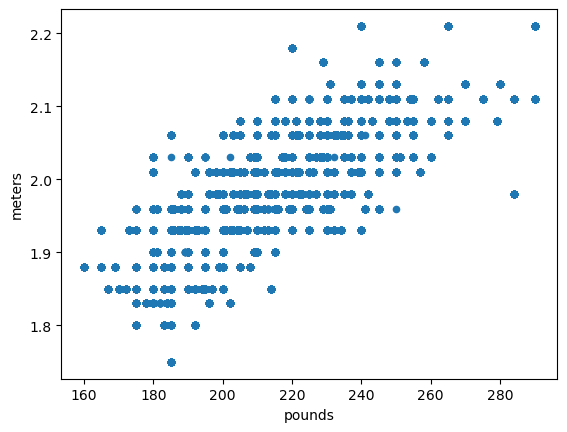

In [8]:
df.plot('pounds', 'meters', 'scatter')

- I think this is a good approach to find some important features in this dataset related to player performance
- I am now going to look at the correlation table for all numeric columns
- Then I will apply a cell highlighter for interesting fields in the correlation matrix with a strong relationship or corerelation (over 70%)

In [9]:
numeric_cols = ['assists', 'blocks', 'defReb', 'fga', 'fgm', 'fgp', 'fta', 'ftm', 'ftp', 'offReb', 'pFouls', 
                'points', 'steals', 'totReb', 'tpa', 'tpm', 'tpp', 'turnovers', 'age', 'meters', 'min', 'plusMinus',
                'pounds', 'years_pro', 'rookie_year', 'jersey_number']

df_corr_c = df[numeric_cols].corr()

df_corr_c.style.map(highlighter)

- This is still a bit awkward to decode so I am going to list the same info as a list with the feature pairs that have the strongest correlation prioritiesd to the top of the list

In [10]:
df_corr_c = df[numeric_cols].corr().abs().unstack().sort_values(ascending=False)
df_corr_c[(df_corr_c < 1) & (df_corr_c >= 0.7)]# exclude below 74% correlation and 100% for matching cols in corr matrix

points       fgm            0.968215
fgm          points         0.968215
fta          ftm            0.953071
ftm          fta            0.953071
defReb       totReb         0.940426
totReb       defReb         0.940426
rookie_year  age            0.900022
age          rookie_year    0.900022
points       fga            0.897463
fga          points         0.897463
fgm          fga            0.897029
fga          fgm            0.897029
tpm          tpa            0.824836
tpa          tpm            0.824836
meters       pounds         0.801738
pounds       meters         0.801738
min          fga            0.794232
fga          min            0.794232
min          points         0.744084
points       min            0.744084
min          fgm            0.728871
fgm          min            0.728871
tpa          fga            0.708842
fga          tpa            0.708842
tpm          tpp            0.705648
tpp          tpm            0.705648
ftp          ftm            0.705585
f

- We can see 'points' (Points scored) and field goals made ('fgm') have the strongest correlation which is interesting.
- We can see other fields of interest that have a strong correlation with 'points' are 'fga' (Field Golas Attempted), and 'min' (Minutes Played)
- Rebounding related fields have a strong relationship (defensive, offensive and total rebounds) which makes sense
- Weight and Height, Field Goal related, Three Pointer features (tpm, tpa), Free Throws (ftp, fta, ftm), and age / years playing professional all figure as field pairs/tuples that have strong correlation which is expected.
- A player that scores a lot of field goals tend to score more points, more so than a higher scoring rate of free throws or three pointers
- On the other side, if we look back at the correlation matrix: Blocks, Steals and Assists are often stand alone performance statistics that to not seem to have a strong correlation with any other feature
- This is also true for categories that have a negative aspect to player performance such as personal founls (pFouls) and turnovers.
- PlusMinus is a very prominent feature as it measures the positive or negative impact and contribution a player has for his team for a given game while on court, over the course of a season this is a telling statistic.

- I would like to view a time series line plot of the avergae player weight per season

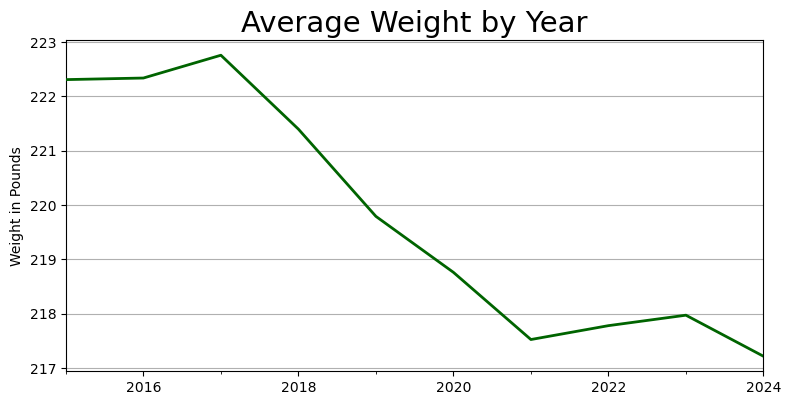

In [11]:
df_weight = df.copy()
df_weight.index = df_weight.index.to_timestamp()

df_weight = df_weight['pounds'].resample("1YE").mean()
create_ts_plot(df_weight, "Average Weight by Year", "Weight in Pounds", "darkgreen");

- From this plot it appears the players are lighter overall since 2015 and trending down in weight by 5/6 lbs from 2015 - 2023
- Lets verify this by checking the mean weight of players per the 2015 season data and again for 2023

In [12]:
avg_weight_2015 = round(df[df.index == '2015']['pounds'].mean(), 2)
print("Average weight for 2015: %s pounds" % avg_weight_2015)

Average weight for 2015: 222.31 pounds


In [13]:
avg_weight_2024 = round(df[df.index == '2024']['pounds'].mean(), 2)
print("Average weight for 2024: %s pounds" % avg_weight_2024)

Average weight for 2024: 217.21 pounds


In [14]:
print("Difference in weight from 2015 to 2024: %s lbs" % (round(avg_weight_2015 - avg_weight_2024, 2)))

Difference in weight from 2015 to 2024: 5.1 lbs


- Heaviest Players in the NBA from 2015-2024

In [15]:
df[['player_name', 'pounds', 'meters', 'feet']].reset_index(drop=True).sort_values(by=['pounds'], ascending=False).drop_duplicates()[0:5]

player_name  pounds  meters  feet
79593   Boban Marjanovic   290.0    2.21   7"3
230879      Jusuf Nurkic   290.0    2.11  6"11
96058       Nikola Jokic   284.0    2.11  6"11
216397   Zion Williamson   284.0    1.98   6"6
247237       Joel Embiid   280.0    2.13   7"0

- Notably Zion Williamson is quite heavy for his height (under 2 meters)

- Lighest Players in the NBA from 2015-2024

In [16]:
df[['player_name', 'pounds', 'meters', 'feet']].reset_index(drop=True).sort_values(by=['pounds'], ascending=True).drop_duplicates()[0:5]

player_name  pounds  meters feet
250481  Tyrell Terry   160.0    1.88  6"2
335401    Isaiah Joe   165.0    1.93  6"4
358675   Xavier Moon   165.0    1.88  6"2
184584      Kyle Guy   167.0    1.85  6"1
358408  Bones Hyland   169.0    1.88  6"2

- View average height for players in 2017

In [17]:
print("Average height for players in 2017: %s meters" % round(df[df.index == '2017']['meters'].mean(), 3))

Average height for players in 2017: 1.998 meters


- View average height for players in 2021

In [18]:
print("Average height for players in 2021: %s meters" % round(df[df.index == '2021']['meters'].mean(), 3))

Average height for players in 2021: 1.99 meters


- I would like to view a time series line plot of the avergae player height per season to get a better idea of this data and trend

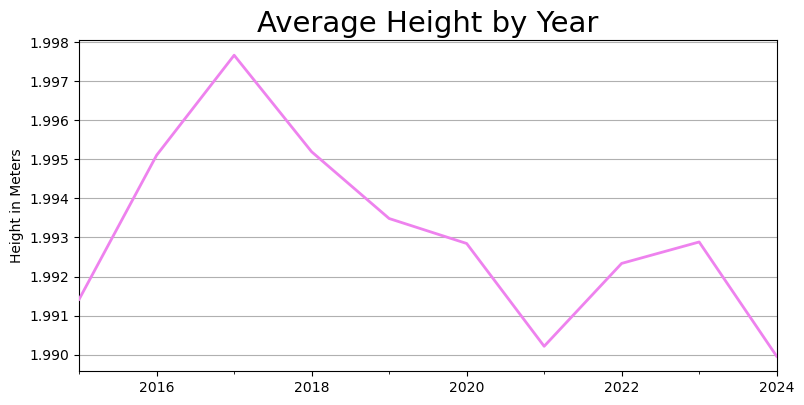

In [19]:
df_height = df.copy()
df_height.index = df_height.index.to_timestamp()

df_height = df_height['meters'].resample("1YE").mean()
create_ts_plot(df_height, "Average Height by Year", 
               "Height in Meters", "violet");

- As opposed to the trend in average player weight (trending down), the average player height has not varied much from 2015 - 2024. 
- The average height staying at 1.99 to 2 meters (6"6 in feet and inches).

- Next, lets get an idea of the distribution of total minutes played by NBA players from 2015-2024
- I would like to know the if it is a normal distribution and are there any outliers

In [20]:
# create histogram visual
mins_played_summary = summary_top_players('player_name', 'min', results = 800)['sum']
h = mins_played_summary.hist(backend='plotly', labels=dict(index='Player Count', value='Minutes Played', 
                                                           variable='Total Minutes Played'))
h.layout.yaxis.title.text = 'Player Count'
h

- Not a bell shape or the expected normal distribution, we can confirm this with the Shapiro-Wilk test where we can reject the null hypothesis when p value is less than 0.05 and say the data does not come from a normal distribution

In [21]:
test_normality = shapiro(mins_played_summary)

print(test_normality)

ShapiroResult(statistic=0.8014081288597795, pvalue=3.564594976648819e-30)


In [22]:
is_not_normal_dist = (test_normality.pvalue < 0.05) and (test_normality.statistic > 0.8)
print("Can we reject the null hypothesis and say this is not a normal distribution (bell shaped): %s" % is_not_normal_dist)

Can we reject the null hypothesis and say this is not a normal distribution (bell shaped): True


- We can see most players fall into bins where they have played less than 5k minutes in this time (the majority have less than 500 mins playing time at a count of 340 players) 
- However, the distribution is right skewed distribution with a gap before a group of players that have between 7.5k and 15k approx. playing minutes in that time frame of 10 years, this may be due to playoff runs of teams that have smaller squads or players that seem to avoid injury more often than not.
- Lets view the players in this group, `Note`: It will be interesting if they end up in the group of players with the best team impact.

In [23]:
df_mins = summary_top_players('player_name', 'min', sort_by = 'sum', results = 20)
df_mins[df_mins['sum'] > 7500]
df_mins

mean      sum
player_name                      
Taurean Prince     24.39  19028.0
Josh Hart          33.61  15258.0
Norman Powell      27.07  15105.0
Domantas Sabonis   34.75  15012.0
Pascal Siakam      34.28  14810.0
Nikola Vucevic     33.15  13858.0
Alex Caruso        24.87  12981.0
Kyrie Irving       36.13  12718.0
Kevin Durant       35.98  12450.0
Jarrett Allen      31.46  12334.0
Malik Beasley      26.21  11796.0
Tim Hardaway Jr.   26.84  11060.0
Mason Plumlee      20.11  10920.0
Terry Rozier       32.66  10844.0
Jerami Grant       33.70  10448.0
Kelly Oubre Jr.    31.12  10268.0
Russell Westbrook  25.76  10048.0
Kyle Lowry         26.95   9862.0
Eric Gordon        26.01   9260.0
Georges Niang      19.93   9090.0

- Lets view the top players in different stat groupings by average (mean is default sort order) or total (sum when specified in `sort_by` parameter) where appropriate.

In [24]:
summary_top_players('player_name', 'points', sort_by = 'sum', results=5)

mean      sum
player_name                      
Kevin Durant       27.01  35170.0
Russell Westbrook  21.16  33398.0
Kyrie Irving       24.24  29574.0
Andre Drummond     12.56  27846.0
Nikola Vucevic     18.16  27172.0

In [25]:
summary_top_players('player_name', 'points', results=5)

mean      sum
player_name                          
Luka Doncic            28.23  13974.0
Kevin Durant           27.01  35170.0
Stephen Curry          26.92  19465.0
Giannis Antetokounmpo  26.45  20475.0
Joel Embiid            26.41  14181.0

In [26]:
summary_top_players('player_name', 'assists', sort_by = 'sum', results=5)

mean      sum
player_name                     
Russell Westbrook  8.58  13532.0
Kyle Lowry         6.23   9276.0
Eric Bledsoe       4.98   7404.0
James Harden       8.71   6952.0
Kyrie Irving       5.46   6658.0

In [27]:
summary_top_players('player_name', 'assists', results=5)

mean      sum
player_name                     
Trae Young         9.38   4757.0
James Harden       8.71   6952.0
John Wall          8.64   6204.0
Russell Westbrook  8.58  13532.0
Tyrese Haliburton  8.57   2802.0

In [28]:
summary_top_players('player_name', 'fgp', sort_by = 'sum', results=5)

mean       sum
player_name                    
JaVale McGee    52.96  146170.4
Mason Plumlee   57.75  134266.2
Andre Drummond  53.20  117955.2
Taurean Prince  40.98  100804.0
Doug McDermott  43.51   93841.5

In [29]:
summary_top_players('player_name', 'ftp', sort_by = 'sum', results=5)# free throw percentage

mean       sum
player_name                       
Kevin Durant       85.17  110896.6
Norman Powell      50.71  110602.5
Gordon Hayward     66.28  106380.6
Russell Westbrook  66.24  104525.6
Mason Plumlee      44.33  103078.5

In [30]:
summary_top_players('player_name', 'tpp', sort_by = 'sum', results=6)# three-point percentage

mean      sum
player_name                   
Taurean Prince  34.07  83812.8
Doug McDermott  34.46  74325.0
Norman Powell   32.36  70580.7
Evan Fournier   35.05  62773.5
Alec Burks      32.77  61352.7
Gordon Hayward  34.49  55351.2

In [31]:
summary_top_players('player_name', 'offReb', sort_by = 'sum', results=5)# offensive rebounds

mean     sum
player_name                   
Andre Drummond    3.94  8742.0
Steven Adams      3.87  5160.0
Mason Plumlee     2.10  4878.0
JaVale McGee      1.39  3848.0
Domantas Sabonis  2.62  3528.0

In [32]:
summary_top_players('player_name', 'defReb', sort_by = 'sum', results=5)# defensive rebounds

mean      sum
player_name                     
Andre Drummond     8.16  18099.0
Nikola Vucevic     8.20  12262.0
Mason Plumlee      4.74  11016.0
Russell Westbrook  6.59  10396.0
Domantas Sabonis   7.63  10276.0

In [33]:
summary_top_players('player_name', 'totReb', results=5)# Total rebounds by average

mean      sum
player_name                          
Andre Drummond         12.11  26841.0
Rudy Gobert            12.00   9447.0
Giannis Antetokounmpo  10.79   8349.0
Karl-Anthony Towns     10.74   7354.0
Anthony Davis          10.74   7369.0

In [34]:
summary_top_players('player_name', 'totReb', sort_by = 'sum', results=5)# Total rebounds by total/sum

mean      sum
player_name                     
Andre Drummond    12.11  26841.0
Mason Plumlee      6.84  15894.0
Nikola Vucevic    10.44  15614.0
Domantas Sabonis  10.26  13804.0
DeAndre Jordan     9.18  12870.0

In [35]:
summary_top_players('player_name', 'blocks', sort_by = 'sum', results=5)# blocked shots

mean     sum
player_name                 
JaVale McGee    0.96  2648.0
Andre Drummond  1.12  2478.0
Mason Plumlee   0.80  1866.0
Kevin Durant    1.26  1640.0
Rudy Gobert     2.02  1586.0

In [36]:
summary_top_players('player_name', 'blocks', results=6)# blocked shots by average

mean     sum
player_name                    
Selom Mawugbe      4.50     9.0
Victor Wembanyama  3.64   393.0
Walker Kessler     2.34   422.0
Chet Holmgren      2.32   255.0
Myles Turner       2.17  1499.0
Anthony Davis      2.15  1472.0

- Notable inclusions here for average blocked shots instead of total/sum blocked shots in 10 years (Highly touted rookies Victor Wenbamyama & Chet Holmgren)

In [37]:
summary_top_players('player_name', 'steals', sort_by = 'sum', results=5)

mean     sum
player_name                    
Andre Drummond     1.29  2871.0
Russell Westbrook  1.50  2364.0
Eric Bledsoe       1.34  2001.0
Taurean Prince     0.80  1960.0
Kyle Lowry         1.28  1900.0

In [38]:
summary_top_players('player_name', 'fgm', sort_by = 'sum', results=5)

mean      sum
player_name                     
Kevin Durant       9.52  12392.0
Russell Westbrook  7.70  12152.0
Andre Drummond     5.22  11562.0
Nikola Vucevic     7.66  11452.0
Kyrie Irving       9.02  11004.0

In [39]:
summary_top_players('player_name', 'fgm', results=6)

mean      sum
player_name                          
DMitrik Trice          10.00     10.0
LeBron James            9.86   7521.0
Giannis Antetokounmpo   9.70   7505.0
Luka Doncic             9.64   4772.0
Kevin Durant            9.52  12392.0
Anthony Davis           9.11   6251.0

In [40]:
summary_top_players('player_name', 'fga', results=5)

mean      sum
player_name                     
Luka Doncic       20.58  10185.0
Donovan Mitchell  19.28  11493.0
Stephen Curry     18.98  13723.0
Damian Lillard    18.90  13588.0
LeBron James      18.84  14378.0

In [41]:
summary_top_players('player_name', 'fga', sort_by='sum', results=5)

mean      sum
player_name                      
Russell Westbrook  17.56  27712.0
Kevin Durant       18.35  23886.0
Nikola Vucevic     15.57  23294.0
Kyrie Irving       18.73  22846.0
Andre Drummond      9.81  21741.0

- Lets look at fgm (Field Goals Made) a bit closer and sort by mean instead of sum for aggregation type, as it has strong correlation with points scored

In [42]:
df_field_goals_made = summary_top_players('player_name', 'fgm')
df_field_goals_made = df_field_goals_made[df_field_goals_made['sum'] > 5000]
df_field_goals_made

mean      sum
player_name                         
LeBron James           9.86   7521.0
Giannis Antetokounmpo  9.70   7505.0
Kevin Durant           9.52  12392.0
Anthony Davis          9.11   6251.0
Kyrie Irving           9.02  11004.0
Stephen Curry          8.95   6468.0

- This is promising as I would expect these players to appear in the elite player group at the end of the analysis
- Lets look at plusMinus score which is a good starting point to see players that contribute well to the team but maybe not in the top 5 of specific areas like points or rebounds.

In [43]:
summary_top_players('player_name', 'plusMinus', sort_by = 'sum')

mean     sum
player_name                 
Kevin Durant    6.47  8420.0
Stephen Curry   7.54  5453.0
Kyrie Irving    4.29  5234.0
Danny Green     3.85  5004.0
Kyle Lowry      3.26  4852.0
Steven Adams    3.48  4632.0
Draymond Green  5.81  4431.0
Pascal Siakam   2.92  4078.0
Nikola Jokic    4.84  4036.0
Jayson Tatum    5.75  3995.0

- We can see players like Kyle Lowry, Pascal Siakam, and Draymond Green figure here and contribute well over time while their average/mean is not at the same level as Stephen Curry or Kevin Durant

- I would like to see the countries represented in the NBA over the past 10 years
- I want to visualise this information by the total minutes played per country

In [44]:
df_country_grp = df.loc[~((df['min'] == 0) | (df['min'].isna()))]

country_grp = df_country_grp.groupby('country')['min'].agg({'sum'}).sort_values('sum', ascending=False)
country_grp

sum
country                         
USA                     949700.0
Canada                   28047.0
Australia                22018.0
France                   21078.0
Germany                  20187.0
Cameroon                 19487.0
Lithuania                15012.0
Montenegro               13888.0
Bahamas                  11729.0
Croatia                  11405.0
Turkey                   10133.0
Serbia                    8326.0
Slovenia                  7689.0
Dominican Republic        7636.0
Japan                     6688.0
United Kingdom            6671.0
Saint Lucia               5888.0
Greece                    5868.0
Latvia                    5702.0
Austria                   4481.0
Bosnia and Herzegovina    4312.0
Nigeria                   4090.0
Jamaica                   3611.0
Spain                     3479.0
Ukraine                   3317.0
New Zealand               3040.0
Sudan                     2261.0
DRC                       1766.0
Angola                    1463.0
South Sudan               1248.0
Italy                      715.0
Brazil                     577.0
Republic of the Congo      234.0
Argentina                  105.0
Gabon                       28.0
Mali                        20.0

- The Bahamas shooting above its weight here (by way of population per Country) with the likes of Buddy Hield & Deandre Ayton

In [45]:
print("The number of countries with representation in the NBA over the last 10 years is: %s" % len(country_grp))# Count of countries represented

The number of countries with representation in the NBA over the last 10 years is: 36


- Lets remove the USA because as expected they are well represented in NBA basketball, far more than any other country

In [46]:
# remove USA (heavily weighted towards players from USA)
hbar = country_grp[1:].plot(backend='plotly', kind='bar', labels = dict(variable='Minutes Played', 
                                                                        value='Total Minutes Played', index='Country'))
hbar.layout.yaxis.title.text = 'Country'
hbar

#### Data Verification Task
- Check the player and games for Mali's total minutes played

In [47]:
df[(df['country'] == 'Mali') & (df['min'] > 0)][['player_name', 'min', 'game_id']]# data verification of minutes played for Mali

player_name   min  game_id
season                              
2023    Cheick Diallo  10.0    12508
2023    Cheick Diallo   5.0    12514
2023    Cheick Diallo   5.0    12546

In [48]:
print("The number of unique NBA players listed from 2015 - 2024 seasons is: %s" % len(df['player_name'].unique()))# number of unique NBA players listed from 2015 - 2024

The number of unique NBA players listed from 2015 - 2024 seasons is: 2044


- Time to try out some more time series visualisations
- Lets view 3 east coast teams by plusMinus score over time

team_name
Boston Celtics     Axes(0.125,0.11;0.775x0.77)
Miami Heat         Axes(0.125,0.11;0.775x0.77)
Milwaukee Bucks    Axes(0.125,0.11;0.775x0.77)
Name: plusMinus, dtype: object

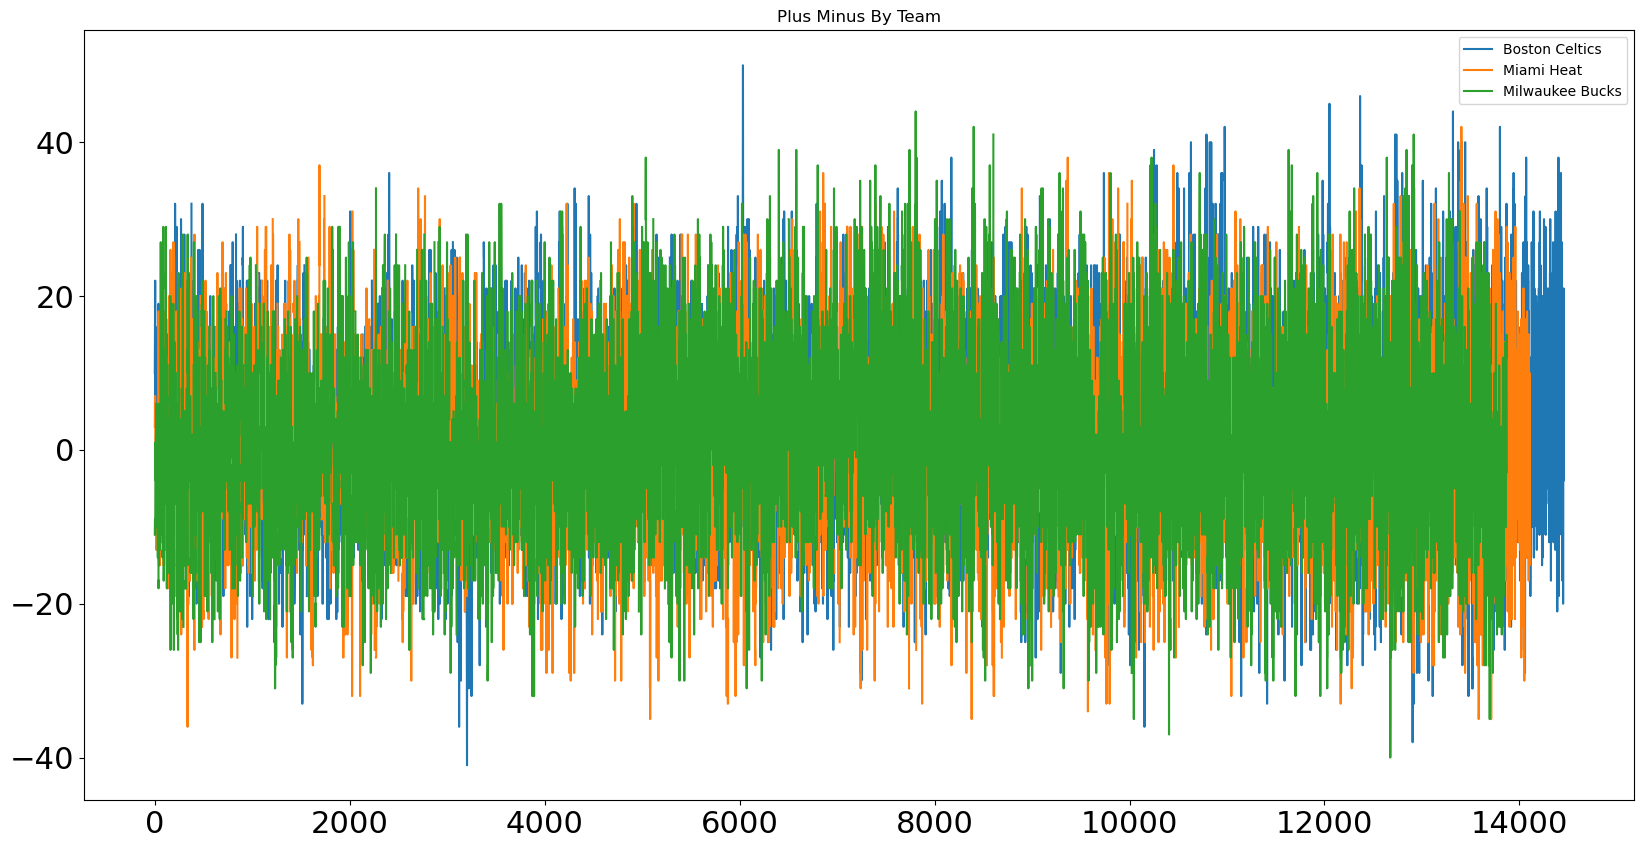

In [49]:
df[df['team_name'].isin({'Boston Celtics', 'Miami Heat', 'Milwaukee Bucks'})].groupby('team_name')['plusMinus'].plot(
    x=df.index.year, legend=True, figsize=(20, 10), use_index=False, title="Plus Minus By Team", 
    fontsize=fontsize, zorder=3)

- Now I want to compare LeBron vs Steph Curry plusMinus score over time as a visual

player_name
LeBron James     Axes(0.125,0.11;0.775x0.77)
Stephen Curry    Axes(0.125,0.11;0.775x0.77)
Name: plusMinus, dtype: object

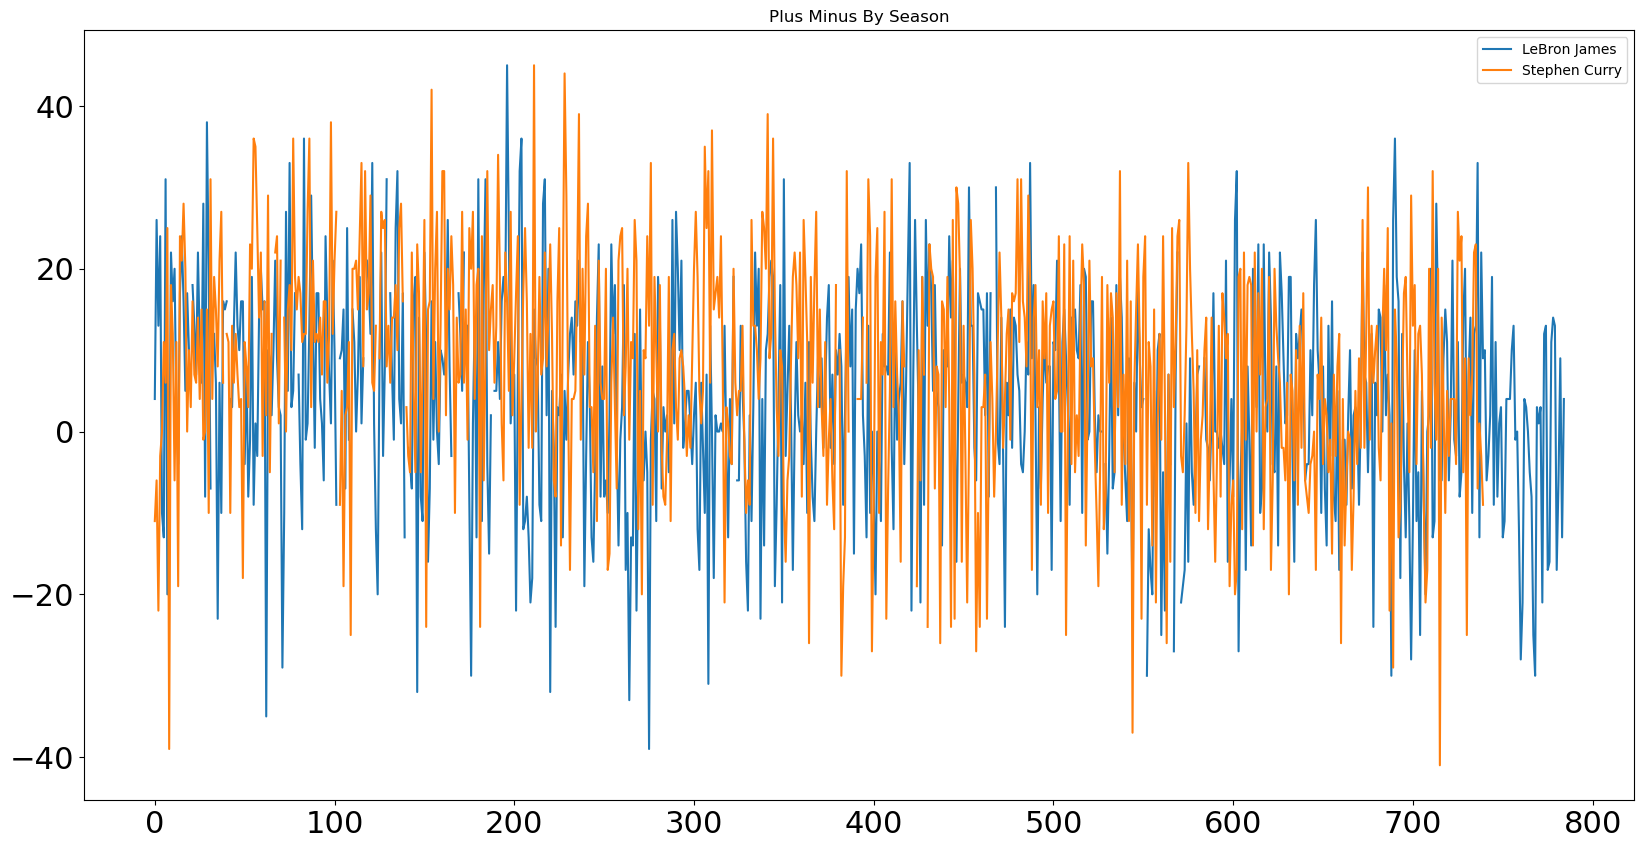

In [50]:
df[df['player_name'].isin({'LeBron James', 'Stephen Curry'})].groupby('player_name')['plusMinus'].plot(
    x=df.index.year, legend=True, figsize=(20, 10), use_index=False, title="Plus Minus By Season", 
    fontsize=fontsize, zorder=3)

- Lets try something similar with visualising season high for points scored for a less noisy plot

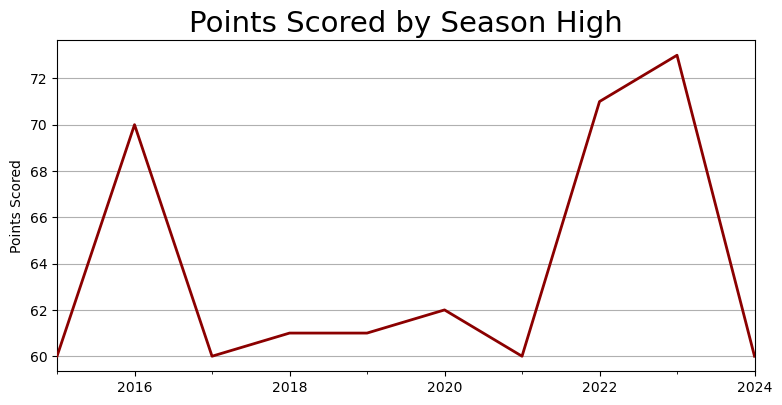

In [51]:
df_pts_per_yr = df.copy()
df_pts_per_yr.index = df_pts_per_yr.index.to_timestamp()

df_pts_per_yr = df_pts_per_yr['points'].resample("1YE").max()
ax = create_ts_plot(df_pts_per_yr, "Points Scored by Season High", "Points Scored", "darkred")

- Standout performances were on the up in 2023 with a season high 73 points (60-73pts was range for 10 years season high)
- Lets do the same for assists

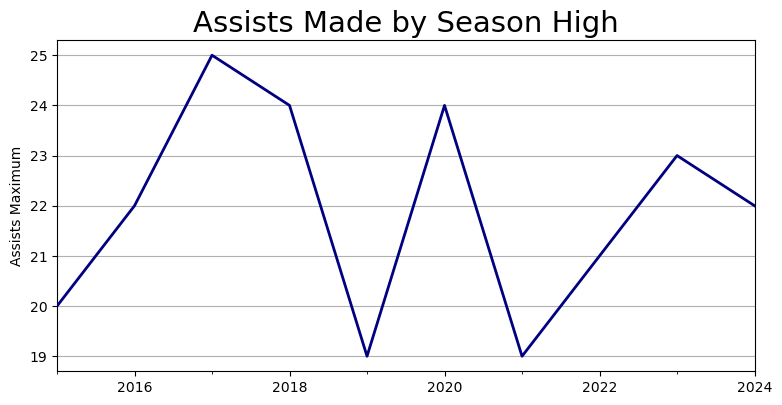

In [52]:
df_assts_per_yr = df.copy()
df_assts_per_yr.index = df_assts_per_yr.index.to_timestamp()

df_assts_per_yr = df_assts_per_yr['assists'].resample("1YE").max()
ax = create_ts_plot(df_assts_per_yr, "Assists Made by Season High", "Assists Maximum")

- 25 assists in a single game was the peak in the past 10 seasons
- The range for season high assists in a single game was [19, 25]
- Lets see the players that achieved these numbers

In [53]:
df[['player_name', 'assists']].sort_values(by='assists', ascending=False)[0:9]

player_name  assists
season                            
2017          Rajon Rondo     25.0
2018    Russell Westbrook     24.0
2020    Russell Westbrook     24.0
2018    Russell Westbrook     24.0
2020    Russell Westbrook     24.0
2023    Tyrese Haliburton     23.0
2016    Russell Westbrook     22.0
2016    Russell Westbrook     22.0
2024           Trae Young     22.0

- Russell Westbrook remarkably appearing 6 times for this milestone (Games from 2016 - 2020)

- Lets take another view at points scored, instead of viewing by season high lets make a box plot to see the avergae, median, outliers

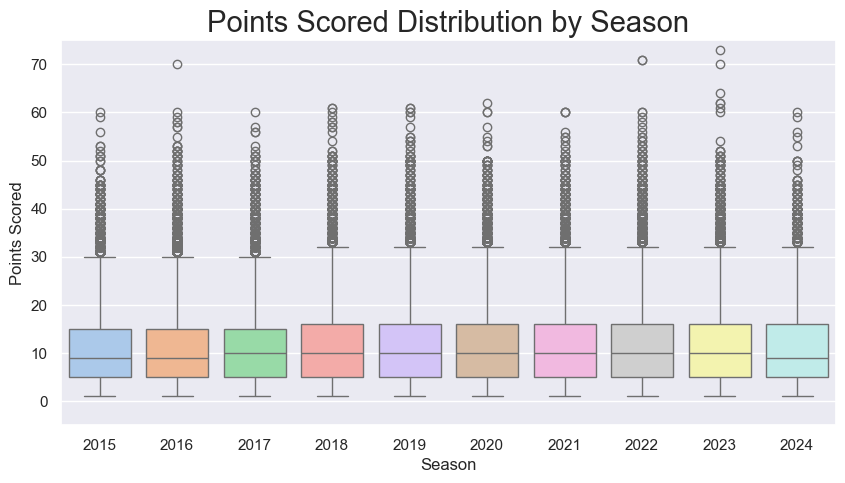

In [54]:
df_pts_high = df.loc[~((df['points'] == 0) | (df['points'].isna()))]
  
sns.set_theme(style="darkgrid")
palette = load_cmap("pastel").hex

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_pts_high, x=df_pts_high.index, y='points', palette=palette, hue='season')
plt.title("Points Scored Distribution by Season", fontsize=fontsize-1)
plt.xlabel("Season")
plt.ylabel("Points Scored");
plt.ylim(-5, 75);

- Again this confirms 22/23' were strong seasons for scoring after lows in 2020/21' (`Note:` 2020/2021 was a shortened season for the covid bubble where lakers won the championship 2020 championship followed by the Bucks in 2021)
- Luka Doncic max for 2023 at 73 pts is the top scoring game over the past 10 years
- Giannis also has his franchise record for the Bucks as a notable outlier in the box plot above and summary table below (64pts in 2023)
- Devin Bookers 70 point game in 2016 is a notable outlier from 2015 all the way up to 20203/2024 when single game scoring started to see some further outliers
- The median generally falling between 7-9 points.
- The bulk of player point totals per game falling between 5 and 15 points

In [55]:
df[['player_name', 'points']].sort_values(by='points', ascending=False)[0:6]# Highest single game scorers in the past 10 years

player_name  points
season                               
2023              Luka Doncic    73.0
2022           Damian Lillard    71.0
2022         Donovan Mitchell    71.0
2016             Devin Booker    70.0
2023              Joel Embiid    70.0
2023    Giannis Antetokounmpo    64.0

- Lets get the descriptive statitics for points and assists over 10 seasons
- We can see the inter quartile range, min, max, standard deviation and averages for the whole data set which again confirms some of the previous analysis

In [56]:
round(df[['points', 'assists']].describe(), 2)

points    assists
count  374176.00  374176.00
mean        9.24       2.01
std         8.44       2.45
min         0.00       0.00
25%         2.00       0.00
50%         8.00       1.00
75%        14.00       3.00
max        73.00      25.00

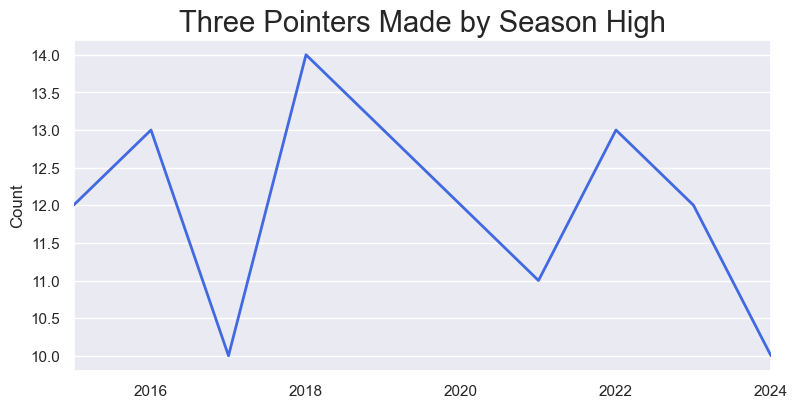

In [57]:
df_tpm_per_yr = df.copy()
df_tpm_per_yr.index = df_tpm_per_yr.index.to_timestamp()
# df_tpm_per_yr.index = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in df_tpm_per_yr.index]

df_tpm_per_yr = df_tpm_per_yr['tpm'].resample("1YE").max()
ax = create_ts_plot(df_tpm_per_yr, "Three Pointers Made by Season High", "Count", "royalblue")

- Lets take a look at the players that made the most 3-pointers in a single game

In [58]:
df[['player_name', 'tpm']].sort_values(by='tpm', ascending=False)[0:6]

player_name   tpm
season                      
2018     Klay Thompson  14.0
2019       Zach LaVine  13.0
2016     Stephen Curry  13.0
2022    Damian Lillard  13.0
2020    Damian Lillard  12.0
2015     Stephen Curry  12.0

- The same analysis for three pointers made in a single game (season high) throws up some interesting results
- Klay Thompsons 14 3pointers remains the peak for the last 9 seasons which means perhaps field goals and free throws made up a lot of the high scoring games mentioned earlier
- The game specific stats are available from another end-point which may be worth adding as a next step to this analysis

- Next, Create function to calculate productivity matrix to generate heat maps and charts for top players in the NBA over the last 10 seasons
- This matrix needs to normalise all numeric features to the range [0, 1]
- I am adding some filters related to minutes played, fouls and turnovers to rule out some players that may not have contributed well over a longer time period (rookies, players injured for long duration etc.) with notable drawbacks to their individual performance.

In [59]:
cols_pos = ['assists', 'blocks', 'steals', 'fgm', 'fgp', 'ftm', 'ftp', 'totReb', 'tpm', 'tpp', 'points', 'min', 'plusMinus']
cols_neg = ['pFouls', 'turnovers', 'min']


def calc_productivity_matrix(df_temp, cols, min_thresh = 0.75):
    # group by player and get mean / averages for 2015-2023 (9 years)
    df_prod = df_temp.groupby("player_name")[cols].mean()

    # min-max normalisation of data frame
    df_norm_prod = (df_prod - df_prod.min()) / (df_prod.max() - df_prod.min())

    # drop records with NA values
    df_prod_heatmap = round(df_norm_prod.dropna(), 2)
    
    # filter out players with less playing experience
    if 'min' in df_prod_heatmap.columns:
        df_prod_heatmap = df_prod_heatmap[df_prod_heatmap['min'] > min_thresh]

    # calculate row sum as a sort of productivity indicator (can be based on positive or negative contributions)
    df_prod_heatmap['player_sum'] = df_prod_heatmap.sum(axis=1)

    # sort and find top 15 players
    df_prod_heatmap = df_prod_heatmap.sort_values('player_sum', ascending=False)[0:24]
    return df_prod_heatmap[cols]

- View matrix of players making a strongly positive impact for their teams

In [60]:
positive_prod = calc_productivity_matrix(df, cols_pos)
positive_prod

assists  blocks  steals   fgm   fgp   ftm   ftp  \
player_name                                                                
James Harden                0.93    0.14    0.38  0.78  0.43  0.93  0.84   
Luka Doncic                 0.86    0.10    0.31  0.96  0.46  0.74  0.72   
Kevin Durant                0.54    0.28    0.21  0.95  0.53  0.73  0.85   
Stephen Curry               0.62    0.07    0.35  0.89  0.47  0.56  0.83   
Joel Embiid                 0.36    0.35    0.22  0.87  0.48  1.00  0.80   
LeBron James                0.84    0.15    0.31  0.99  0.52  0.56  0.70   
Giannis Antetokounmpo       0.57    0.29    0.29  0.97  0.55  0.79  0.67   
Damian Lillard              0.72    0.07    0.25  0.83  0.43  0.80  0.87   
Victor Wembanyama           0.40    0.81    0.29  0.81  0.47  0.49  0.77   
Trae Young                  1.00    0.03    0.26  0.78  0.42  0.81  0.82   
Anthony Davis               0.29    0.48    0.32  0.91  0.51  0.74  0.75   
Nikola Jokic                0.73    0.16    0.30  0.82  0.55  0.48  0.72   
Kawhi Leonard               0.39    0.14    0.42  0.84  0.49  0.63  0.80   
Jayson Tatum                0.40    0.15    0.28  0.80  0.45  0.58  0.75   
Kyrie Irving                0.58    0.11    0.31  0.90  0.48  0.45  0.78   
Paul George                 0.43    0.09    0.42  0.77  0.43  0.57  0.76   
Karl-Anthony Towns          0.33    0.27    0.19  0.81  0.52  0.55  0.78   
Donovan Mitchell            0.49    0.07    0.34  0.86  0.44  0.51  0.75   
Anthony Edwards             0.44    0.14    0.33  0.83  0.44  0.48  0.72   
Shai Gilgeous-Alexander     0.52    0.18    0.35  0.80  0.49  0.69  0.77   
LaMelo Ball                 0.76    0.07    0.37  0.72  0.41  0.38  0.70   
Jimmy Butler                0.54    0.10    0.42  0.67  0.47  0.79  0.79   
Ja Morant                   0.79    0.07    0.26  0.81  0.46  0.61  0.71   
Devin Booker                0.52    0.06    0.21  0.82  0.44  0.63  0.78   

                         totReb   tpm   tpp  points   min  plusMinus  
player_name                                                           
James Harden               0.52  0.70  0.35    0.93  0.94       0.58  
Luka Doncic                0.71  0.66  0.33    1.00  1.00       0.55  
Kevin Durant               0.58  0.48  0.40    0.96  0.97       0.63  
Stephen Curry              0.42  1.00  0.41    0.95  0.88       0.66  
Joel Embiid                0.88  0.24  0.31    0.94  0.92       0.61  
LeBron James               0.66  0.42  0.33    0.92  0.95       0.58  
Giannis Antetokounmpo      0.89  0.16  0.23    0.94  0.91       0.59  
Damian Lillard             0.36  0.73  0.35    0.93  0.96       0.55  
Victor Wembanyama          0.86  0.49  0.32    0.79  0.82       0.50  
Trae Young                 0.29  0.57  0.33    0.87  0.94       0.49  
Anthony Davis              0.89  0.14  0.22    0.88  0.93       0.54  
Nikola Jokic               0.89  0.24  0.32    0.76  0.94       0.60  
Kawhi Leonard              0.53  0.42  0.38    0.84  0.90       0.63  
Jayson Tatum               0.61  0.55  0.36    0.82  0.99       0.62  
Kyrie Irving               0.34  0.57  0.38    0.86  0.98       0.59  
Paul George                0.53  0.65  0.38    0.81  0.90       0.58  
Karl-Anthony Towns         0.89  0.37  0.37    0.79  0.89       0.53  
Donovan Mitchell           0.35  0.65  0.36    0.86  0.94       0.58  
Anthony Edwards            0.43  0.61  0.35    0.82  0.97       0.53  
Shai Gilgeous-Alexander    0.39  0.28  0.34    0.80  0.93       0.54  
LaMelo Ball                0.49  0.64  0.34    0.72  0.88       0.47  
Jimmy Butler               0.47  0.18  0.26    0.73  0.91       0.56  
Ja Morant                  0.40  0.29  0.29    0.79  0.84       0.56  
Devin Booker               0.32  0.45  0.33    0.83  0.96       0.51

- View matrix of players that have a bias/weight against the positive contributions they make (fouls and turnovers can be costly especially on a regular basis)

In [61]:
negative_prod = calc_productivity_matrix(df, cols_neg)
negative_prod

pFouls  turnovers   min
player_name                                   
James Harden             0.42       1.00  0.94
Luka Doncic              0.38       0.93  1.00
Trae Young               0.30       0.98  0.94
Joel Embiid              0.50       0.79  0.92
Cade Cunningham          0.47       0.84  0.89
LaMelo Ball              0.52       0.78  0.88
Giannis Antetokounmpo    0.50       0.76  0.91
Devin Booker             0.48       0.68  0.96
Julius Randle            0.50       0.66  0.93
LeBron James             0.29       0.85  0.95
Nikola Jokic             0.46       0.68  0.94
Karl-Anthony Towns       0.56       0.62  0.89
Domantas Sabonis         0.52       0.59  0.94
Victor Wembanyama        0.36       0.85  0.82
Kevin Durant             0.33       0.72  0.97
Paul George              0.45       0.67  0.90
De'Aaron Fox             0.43       0.63  0.94
Donovan Mitchell         0.40       0.64  0.94
Anthony Edwards          0.35       0.66  0.97
Paolo Banchero           0.35       0.69  0.92
Stephen Curry            0.35       0.72  0.88
Jaden Ivey               0.47       0.67  0.80
Draymond Green           0.51       0.63  0.79
Damian Lillard           0.30       0.67  0.96

- View heatmap with annotations of positive player productivity 
- Dark squares map to low scores and pale squares map to higher ranking annotation or score for the given player/feature

<Axes: ylabel='player_name'>

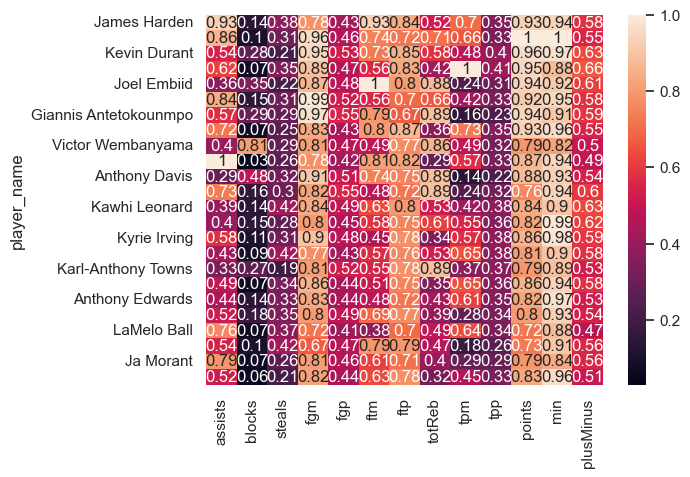

In [62]:
sns.heatmap(positive_prod, annot=True)

- View heatmap with annotations of negative player productivity 

<Axes: ylabel='player_name'>

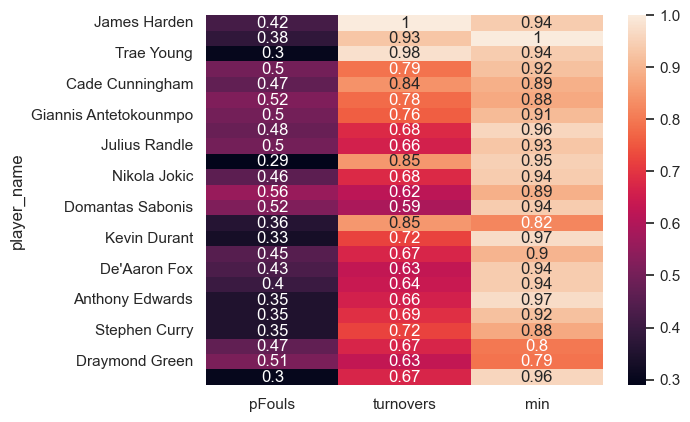

In [63]:
sns.heatmap(negative_prod, annot=True)

- We can see James Harden has a very high turnover rate along with Luka Doncic and Trae Young
- Next, lets use the players appearing high up in the list for turnovers/personal fouls as another layer of selection criteria that we can use to exclude players from the top team players in the NBA over the past 10 years

In [64]:
players_to_exclude = positive_prod.index.intersection(negative_prod.index)
players_to_exclude

Index(['James Harden', 'Luka Doncic', 'Kevin Durant', 'Stephen Curry',
       'Joel Embiid', 'LeBron James', 'Giannis Antetokounmpo',
       'Damian Lillard', 'Victor Wembanyama', 'Trae Young', 'Nikola Jokic',
       'Paul George', 'Karl-Anthony Towns', 'Donovan Mitchell',
       'Anthony Edwards', 'LaMelo Ball', 'Devin Booker'],
      dtype='object', name='player_name')

- Lets view the heat map table after excluding players with some drawbacks to their general play/performance (fouls & turnovers, not enough playing time etc.)
- `James Harden`, `Luka Doncic`, `Kevin Durant`, `Joel Embiid`, `LeBron James`, `Giannis Antetokounmpo`, `Trae Young`, `Nikola Jokic`, and `Paul George` all lose out here and are all household names in the NBA

In [65]:
df_team_pos_players = positive_prod[~positive_prod.index.isin(players_to_exclude)]
df_team_pos_players

assists  blocks  steals   fgm   fgp   ftm   ftp  \
player_name                                                                
Anthony Davis               0.29    0.48    0.32  0.91  0.51  0.74  0.75   
Kawhi Leonard               0.39    0.14    0.42  0.84  0.49  0.63  0.80   
Jayson Tatum                0.40    0.15    0.28  0.80  0.45  0.58  0.75   
Kyrie Irving                0.58    0.11    0.31  0.90  0.48  0.45  0.78   
Shai Gilgeous-Alexander     0.52    0.18    0.35  0.80  0.49  0.69  0.77   
Jimmy Butler                0.54    0.10    0.42  0.67  0.47  0.79  0.79   
Ja Morant                   0.79    0.07    0.26  0.81  0.46  0.61  0.71   

                         totReb   tpm   tpp  points   min  plusMinus  
player_name                                                           
Anthony Davis              0.89  0.14  0.22    0.88  0.93       0.54  
Kawhi Leonard              0.53  0.42  0.38    0.84  0.90       0.63  
Jayson Tatum               0.61  0.55  0.36    0.82  0.99       0.62  
Kyrie Irving               0.34  0.57  0.38    0.86  0.98       0.59  
Shai Gilgeous-Alexander    0.39  0.28  0.34    0.80  0.93       0.54  
Jimmy Butler               0.47  0.18  0.26    0.73  0.91       0.56  
Ja Morant                  0.40  0.29  0.29    0.79  0.84       0.56

- This is the final elite group, I would like to display further information about these players

In [66]:
df_elite_players = df[df['player_name'].isin(df_team_pos_players.index)][['player_name', 'team_name', 'active', 'years_pro', 'affiliation', 'college', 'country', 'age', 'rookie_year']].reset_index(drop=True).drop_duplicates().sort_values('player_name')
df_elite_players.reset_index().sort_values(by=['player_name', 'index'], ascending=[True, False])

index              player_name               team_name active  years_pro  \
1    1919            Anthony Davis      Los Angeles Lakers   True        9.0   
0       0            Anthony Davis    New Orleans Pelicans   True        9.0   
2    2016                Ja Morant       Memphis Grizzlies    NaN        NaN   
3     909             Jayson Tatum          Boston Celtics   True        4.0   
4    2229             Jimmy Butler              Miami Heat   True       10.0   
7    1840             Jimmy Butler      Philadelphia 76ers   True       10.0   
6    1014             Jimmy Butler  Minnesota Timberwolves   True       10.0   
5     230             Jimmy Butler           Chicago Bulls   True       10.0   
9    2146            Kawhi Leonard             LA Clippers   True       10.0   
10   1320            Kawhi Leonard         Toronto Raptors   True       10.0   
8     319            Kawhi Leonard       San Antonio Spurs   True       10.0   
12   3680             Kyrie Irving        Dallas Mavericks   True       10.0   
11   2094             Kyrie Irving           Brooklyn Nets   True       10.0   
13    940             Kyrie Irving          Boston Celtics   True       10.0   
14     80             Kyrie Irving     Cleveland Cavaliers   True       10.0   
15   2324  Shai Gilgeous-Alexander   Oklahoma City Thunder    NaN        NaN   
16   1741  Shai Gilgeous-Alexander             LA Clippers    NaN        NaN   

            affiliation          college    country   age  rookie_year  
1          Kentucky/USA         Kentucky        USA  32.0       2012.0  
0          Kentucky/USA         Kentucky        USA  32.0       2012.0  
2                   NaN              NaN        NaN   NaN          NaN  
3              Duke/USA             Duke        USA  27.0       2017.0  
4         Marquette/USA        Marquette        USA  35.0       2011.0  
7         Marquette/USA        Marquette        USA  35.0       2011.0  
6         Marquette/USA        Marquette        USA  35.0       2011.0  
5         Marquette/USA        Marquette        USA  35.0       2011.0  
9   San Diego State/USA  San Diego State        USA  33.0       2011.0  
10  San Diego State/USA  San Diego State        USA  33.0       2011.0  
8   San Diego State/USA  San Diego State        USA  33.0       2011.0  
12       Duke/Australia             Duke  Australia  33.0       2011.0  
11       Duke/Australia             Duke  Australia  33.0       2011.0  
13       Duke/Australia             Duke  Australia  33.0       2011.0  
14       Duke/Australia             Duke  Australia  33.0       2011.0  
15                  NaN              NaN        NaN   NaN          NaN  
16                  NaN              NaN        NaN   NaN          NaN

- We can see all players are active, the teams they have represented (most recent record is where index value is highest), country and college info, age and when they turned professional.
- `Jimmy Butler` is the oldest and most experienced player in this group followed by `Kawhi Leonard`.
- We can see `Jayson Tatum & Ja Morant` are loyal players as they have stayed with the team that drafted them to this point.
- `Shai Gilgeous-Alexander` is the only non-american on the list, a Canadian (Kyrie has dual citizenship with Austrailia).
- Note missing data for younger players and rookies.
- This is a bit messy for players that have represented more than one team in the 10 year timeframe so lets get the most recent team information for each of these players only (to reduce the noise / record count).

In [67]:
df_elite_players.sort_index(axis=0, ascending=False).groupby('player_name').first()

team_name active  years_pro  \
player_name                                                        
Anthony Davis               Los Angeles Lakers   True        9.0   
Ja Morant                    Memphis Grizzlies   None        NaN   
Jayson Tatum                    Boston Celtics   True        4.0   
Jimmy Butler                        Miami Heat   True       10.0   
Kawhi Leonard                      LA Clippers   True       10.0   
Kyrie Irving                  Dallas Mavericks   True       10.0   
Shai Gilgeous-Alexander  Oklahoma City Thunder   None        NaN   

                                 affiliation          college    country  \
player_name                                                                
Anthony Davis                   Kentucky/USA         Kentucky        USA   
Ja Morant                               None             None       None   
Jayson Tatum                        Duke/USA             Duke        USA   
Jimmy Butler                   Marquette/USA        Marquette        USA   
Kawhi Leonard            San Diego State/USA  San Diego State        USA   
Kyrie Irving                  Duke/Australia             Duke  Australia   
Shai Gilgeous-Alexander                 None             None       None   

                          age  rookie_year  
player_name                                 
Anthony Davis            32.0       2012.0  
Ja Morant                 NaN          NaN  
Jayson Tatum             27.0       2017.0  
Jimmy Butler             35.0       2011.0  
Kawhi Leonard            33.0       2011.0  
Kyrie Irving             33.0       2011.0  
Shai Gilgeous-Alexander   NaN          NaN

- Now we see one record for each player and only for the team they currently represent
- `Ja Morant, Jayson Tatum & Shai Gilgeous-Alexander` have time on their side to improve their respective rankings as the other players are professionals for 9 years or longer

- Lets view the productivity table as a heatmap to help identify where each player excels
- The darker the cell background, the better or the higher the player ranking for the given feature used for analysis

In [68]:
df_team_pos_players.style.background_gradient(cmap='Blues')

- We can already see a pattern emerging for the order of the list, tpp (three-point percentage), points and plusMinus are basically going from a paler square or light blue to navy as we go to the top of the list with Anthony Davis.
- Lets try this in a Seaborn line plot instead to see if there are any other obvious patterns
- Heat Maps (Numbers/Annotations/Cell colours etc.) sometimes dont show the obvious gap in some areas

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

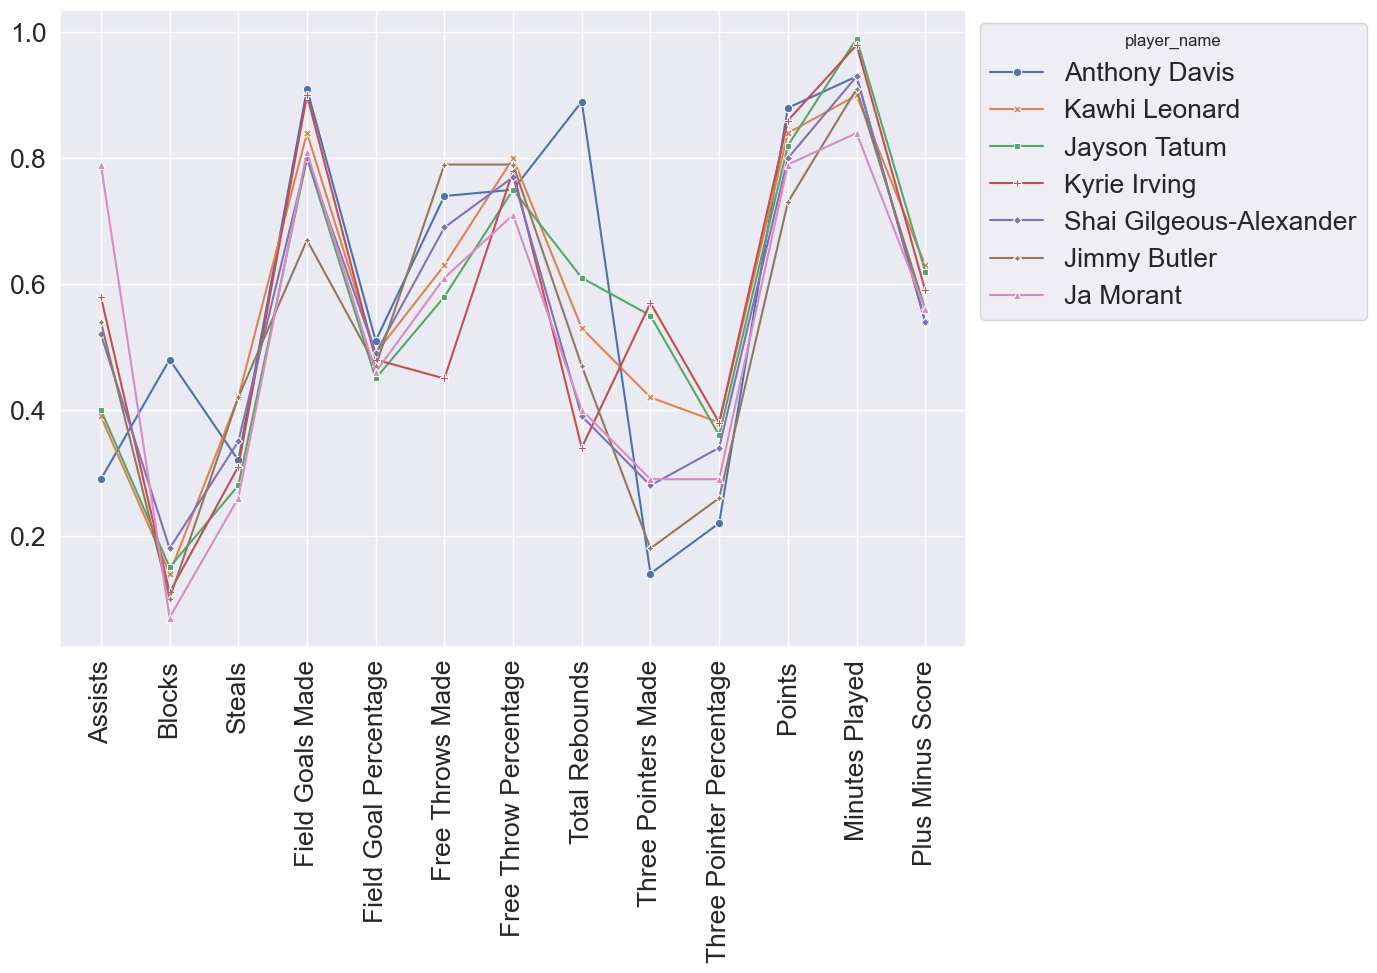

In [69]:
a4_dims= [11.7, 8.27]
fig, ax = plt.subplots(figsize=a4_dims)
df_team_pos_players = df_team_pos_players.rename(columns={'assists': 'Assists',
                                                          'blocks': 'Blocks',
                                                          'steals': 'Steals',
                                                          'fgm' : 'Field Goals Made',
                                                          'fgp' : 'Field Goal Percentage',
                                                          'ftm' : 'Free Throws Made',
                                                          'ftp' : 'Free Throw Percentage',
                                                          'totReb' : 'Total Rebounds',
                                                          'tpm' : 'Three Pointers Made',
                                                          'tpp' : 'Three Pointer Percentage',
                                                          'points': 'Points',
                                                          'min': 'Minutes Played',
                                                          'plusMinus': 'Plus Minus Score'})
ax = sns.lineplot(ax=ax, data=df_team_pos_players.T, markers=True, dashes=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1), fontsize=19)
plt.xticks(rotation = "vertical", fontsize=19)
plt.yticks(fontsize=19)

- Anthony Davis is a ntoable shot blocker here (green line).
    - This is interesting because, through previous analysis, the latest number 1 draft pick has a similar trajectory to `Anthony Davis` because they are both extremely good shot blockers and rebounders, However, `Victor Wembanyama` of `France` has the ability to shoot well from three point range and possibly peform even better in relation to assists and blocks.
- I want to view this theory by displaying AD against Victor in this format (Experience Vs Youth).

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9'),
  Text(0, 1.0, '1.0')])

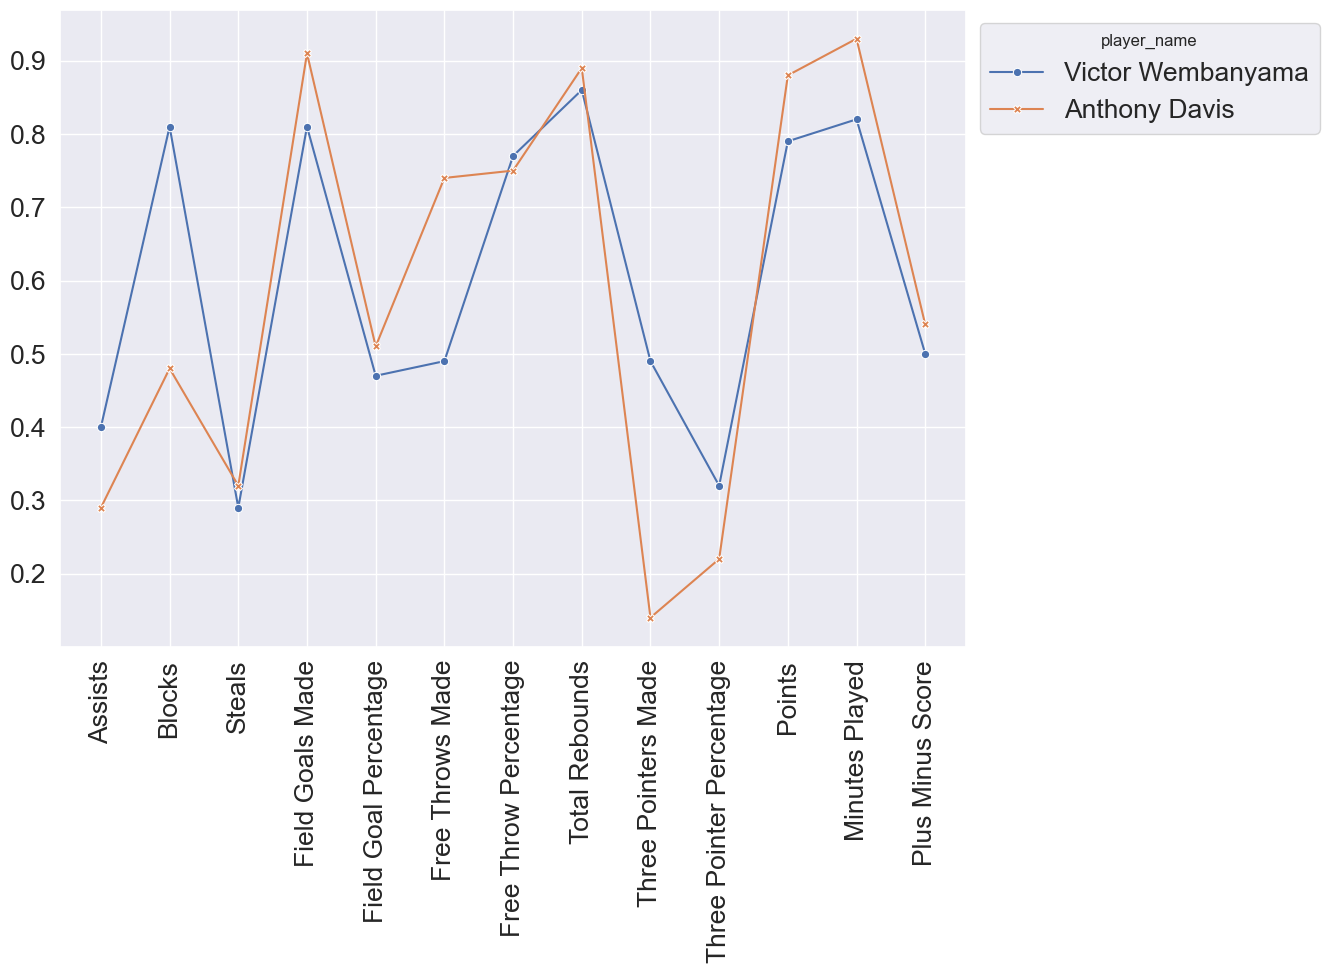

In [70]:
df_matrix_70 = calc_productivity_matrix(df, cols_pos, min_thresh=0.7)# lower minustes played threshold to pull in less experienced pros and rookies that are performing well
df_victor_ad = df_matrix_70[df_matrix_70.index.isin(['Victor Wembanyama', 'Anthony Davis'])]
a4_dims= [11.7, 8.27]
fig, ax = plt.subplots(figsize=a4_dims)
df_victor_ad = df_victor_ad.rename(columns={'assists': 'Assists',
                                                          'blocks': 'Blocks',
                                                          'steals': 'Steals',
                                                          'fgm' : 'Field Goals Made',
                                                          'fgp' : 'Field Goal Percentage',
                                                          'ftm' : 'Free Throws Made',
                                                          'ftp' : 'Free Throw Percentage',
                                                          'totReb' : 'Total Rebounds',
                                                          'tpm' : 'Three Pointers Made',
                                                          'tpp' : 'Three Pointer Percentage',
                                                          'points': 'Points',
                                                          'min': 'Minutes Played',
                                                          'plusMinus': 'Plus Minus Score'})
ax = sns.lineplot(ax=ax, data=df_victor_ad.T, markers=True, dashes=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1), fontsize=19)
plt.xticks(rotation = "vertical", fontsize=19)
plt.yticks(fontsize=19)



- Overall, we can see ADs experience shines through but very promising stats so far from the latest #1 draft pick

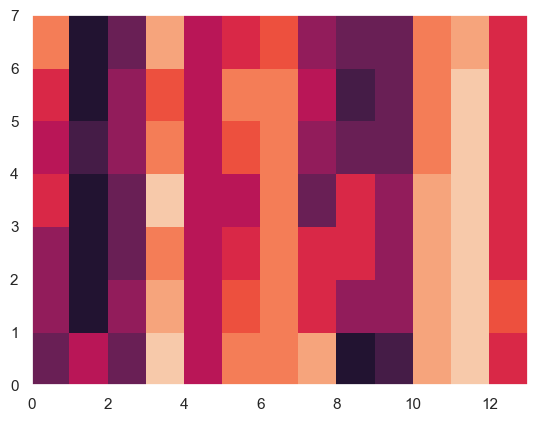

In [71]:
plt.pcolor(df_team_pos_players)

- We can see how yellow matches up with the pale colours below and navy above matches closely to black or low ranking squares below
- The annotations and index labelling really is helpful for decoding and making sense of this visualisation though so it is important to try different libraries/packages when possible like plotly, mathplotlib, Seaborn, Bokeh etc.
- Seaborn on this occasion is a better visual with more information packed in automatically, I like because it is easy to use.

<Axes: ylabel='player_name'>

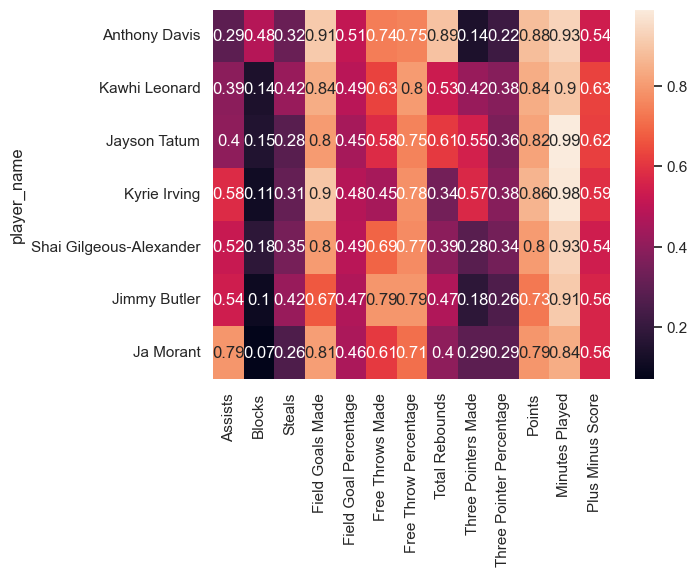

In [72]:
sns.heatmap(df_team_pos_players, annot=True)

- After messing around with different visuals of this final elite group of players, I think an interactive stacked bar chart might be the best option for this data overall.
- Lets view each players bar chart first after we set a color for each statistic type

In [73]:
stat_cols = ['Assists', 'Blocks', 'Steals', 'Field Goals Made', 'Field Goal Percentage', 'Free Throws Made', 
             'Free Throw Percentage', 'Total Rebounds', 'Three Pointers Made', 'Three Pointer Percentage', 'Points',
             'Minutes Played', 'Plus Minus Score']
colours = ["limegreen", "red", "navy", "lightblue", "darkorange", "pink", "lightgreen", "orange", "darkgreen",
           "purple", "blue", "darkred", "yellow"]

stats_colours = dict(zip(stat_cols, colours))
stats_colours

{'Assists': 'limegreen',
 'Blocks': 'red',
 'Steals': 'navy',
 'Field Goals Made': 'lightblue',
 'Field Goal Percentage': 'darkorange',
 'Free Throws Made': 'pink',
 'Free Throw Percentage': 'lightgreen',
 'Total Rebounds': 'orange',
 'Three Pointers Made': 'darkgreen',
 'Three Pointer Percentage': 'purple',
 'Points': 'blue',
 'Minutes Played': 'darkred',
 'Plus Minus Score': 'yellow'}

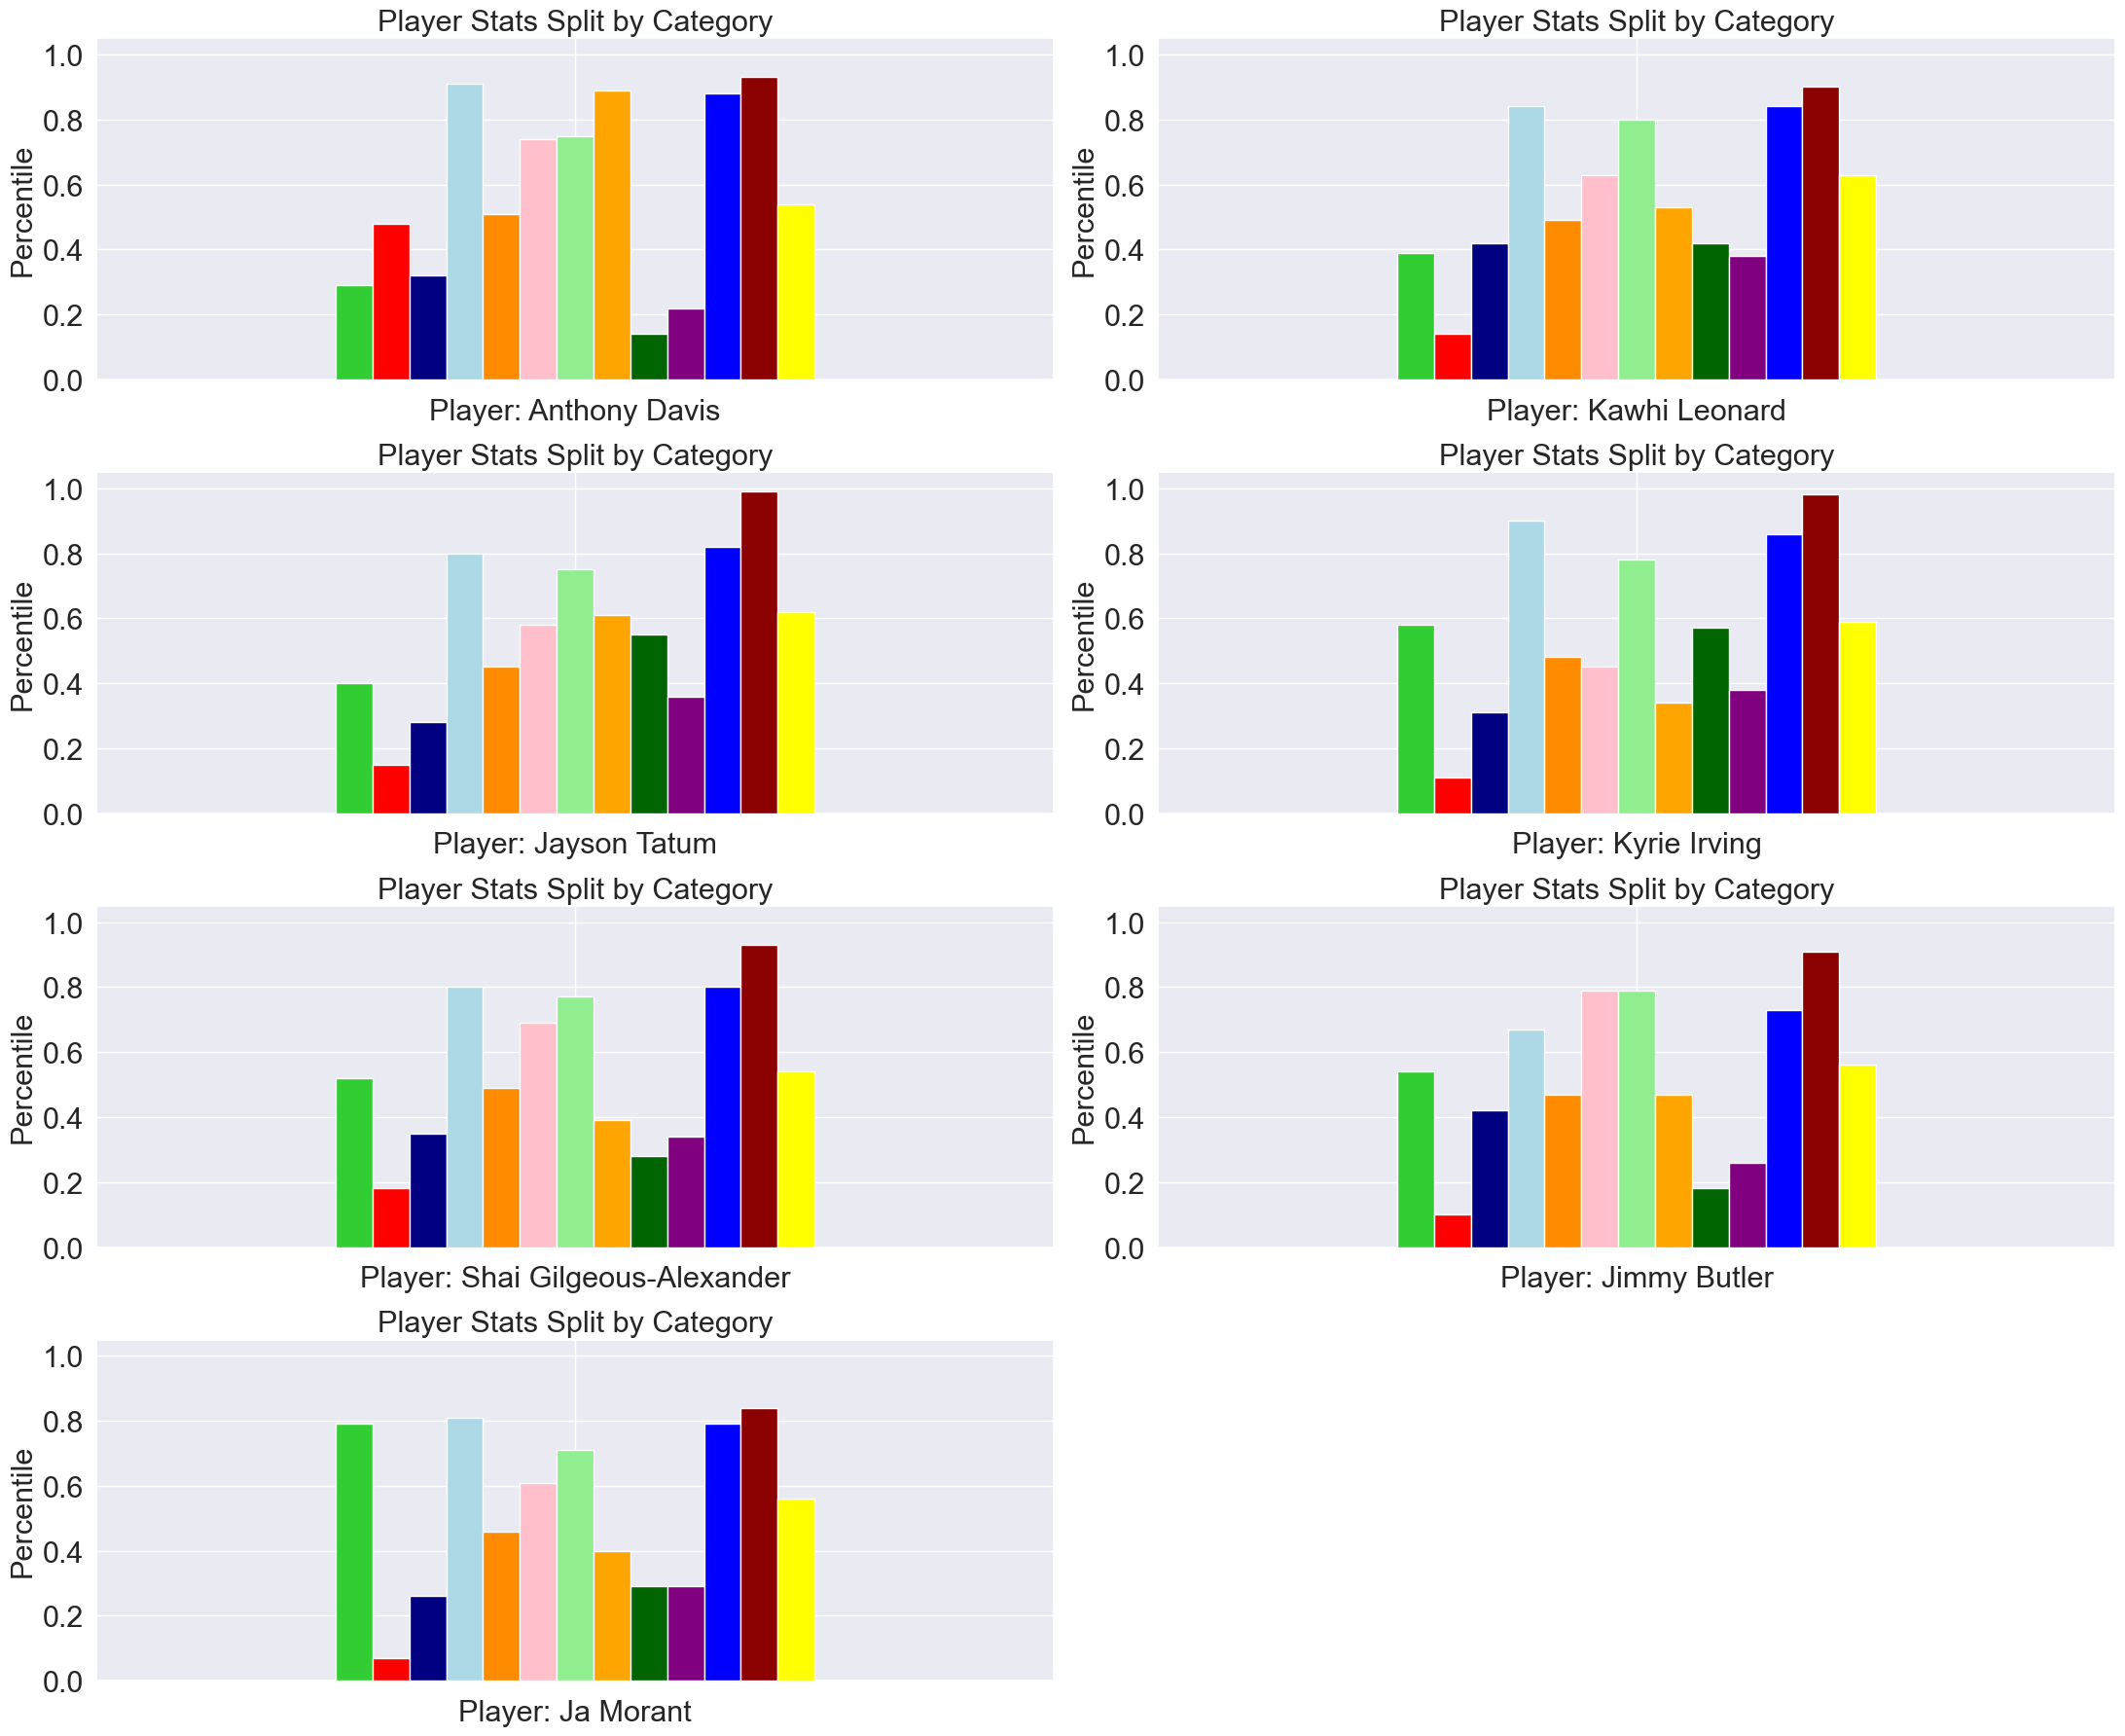

In [74]:
fig = plt.figure(figsize=(22, 22))
for i, player in enumerate(df_team_pos_players.index):
    # create the sub plot
    axc = fig.add_subplot(5, 2, i+1)
    ax = df_team_pos_players[df_team_pos_players.index == player].plot.bar(ax=axc, 
                                                                           legend=False,
                                                                           y=stat_cols, 
                                                                           color=stats_colours, 
                                                                           fontsize=fontsize, 
                                                                           zorder=3)
    # configure axis ticks / labels
    xticklabels = ""
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(xticklabels))
    ax.set_title("Player Stats Split by Category", fontsize=fontsize)
    ax.set_xlabel("Player: %s" % player, fontsize=fontsize)
    ax.set_ylabel("Percentile", fontsize=fontsize)
    ax.set_ylim([.0, 1.05])
    ax.yaxis.grid=True;
fig.tight_layout()                                               

- Lets merge this visualisation into one interactive plot

In [75]:
result_bc = df_team_pos_players.plot(backend='plotly', kind='bar', labels=dict(variable='Stat Category', 
                                                                               value='Normalised Proportion of Productivity'))
result_bc.layout.xaxis.title.text = 'Player Name'
result_bc

- This `visual helps decode where the top players are particularly strong and possible areas of improvement`.
- This is strong evidence for players that are within or atleast close to the top 10 performing players in the NBA over the last 10 seasons
- Notably the minutes played, points, plusMinus score, steals, and FTP (free throw percentage) area of bars is similar for all players in this group.
- `Three pointers, assists, blocks and rebounds` are key areas of differentiation at the top end of the NBA judging by this visual.

### 3. Discussion

- The data used is spread across `2 different endpoints` with a limitation that only data from the years `2015-2024` is available. The volume of data involved is still quite substantial at `more than 320,000 records`.
- The data used is from over `540` API requests and there was a lot of time trying to pre-process and merge this data into something useful via player ID and other features.
- There was a lot of `nested JSON objects` that had features I needed to extract, parse and format into something useful for the analysis here.
- There were other difficulties such as `missing Country and College` information etc. for rookies or lesser known players such as Victor Wembanyama so the API covers a lot and is being updated all the time but is not perfect.
- Data verification tasks included searching online for the single game records for points, assists, and three pointers made in the past 10 years. In addition, I completed some verification of the data actually loaded into the notebook along with some other spot checks (ongoing task for data of this nature as it is being updated all the time).
- The key insights were the `top players by statistic` (total and averges) for certain stats in the NBA along with the final stacked bar chart and heatmaps which help identify some of the `most productive and high performing players` over the last `10 years`.

- I was able to track down a group of players that represent an `elite group that best contributed to their respective teams over a 10 year period` (3 players `Jimmy Butler, Shai Gilgeous-Alexander, & Ja Morant` that have yet to win a championship ring but have featured in several playoff series and all star weekends etc.).

- I think the next step would be to pull `game data and statistics` by game ID. We could then use this in combination with player ID and team ID (as some players have moved / were traded to several different teams over the years) to merge this data into the main DataFrame to get an idea of the win rate associated with the players here and the split of `regular season statistics vs playoff games`. 

- I would like to also see how player performance varies from one franchise to another, such as `LeBron at Miami vs LeBron at the Lakers`. 

- Right now it is hard to see which data is regular or post season and what players do not perform well in the playoffs vs regular season games. This would be another key insight to try visualise, perhaps more important than the average 'plusMinus' score or the method I have used to find the most impactful NBA players over the last 10 seasons.

- I think a view of the final stacked bar chart per season would allow to see what players are trending up and what players are trending down in their performance levels. This may show that I wrongly excluded players like: `James Harden`, `Luka Doncic`, `Kevin Durant`, `Joel Embiid`, `LeBron James`, `Giannis Antetokounmpo`, `Trae Young`, `Nikola Jokic`, and `Paul George` from the final elite players group for the past 10 years. However, from the players excluded, `Durant, LeBron, Giannis and Nikola` are the players to be part of a winning championship team. To that end, `Gianis` and `Nikola Jokic` are under 30, while `LeBron` and `Kevin Durant` are 40 & 36 years of age respectively. 